Text(0, 0.5, 'nominal rate, in %')

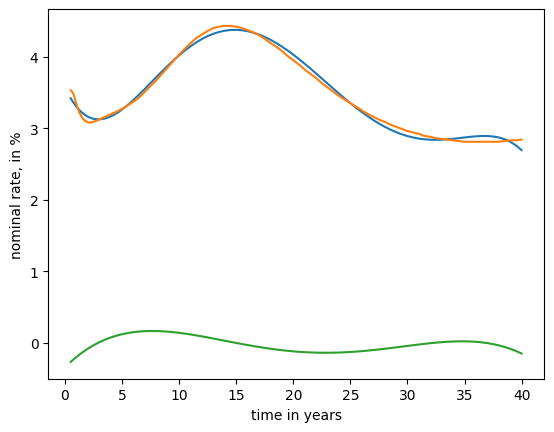

In [2]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("jan_curve.csv", delimiter=",", dtype=float)
# the jan_curve file comes from GLC Nominal month end data_2016 to present, the jan 2023 curve, which is data from the Bank of England

x = data[:,0]
y = data[:,1]

spl = interpolate.UnivariateSpline(x,y,k=5)
plt.plot(x,spl(x))
plt.plot(x,y)
plt.plot(x,spl.derivative()(x))
plt.xlabel("time in years")
plt.ylabel("nominal rate, in %")

40
[-0.09592369 -0.06244385 -0.03235271 -0.00548885  0.01830917  0.03920281
  0.0573535   0.07292267  0.08607178  0.09696226  0.10575556  0.11261311
  0.11769636  0.12116674  0.1231857   0.12391468  0.12351512  0.12214847
  0.11997615  0.11715962  0.11386031  0.11023967  0.10645913  0.10268015
  0.09906415  0.09577258  0.09296688  0.09080849  0.08945885  0.08907941
  0.08983161  0.09187688  0.09537666  0.10049241  0.10738555  0.11621753
  0.1271498   0.14034378  0.15596093  0.17416268]


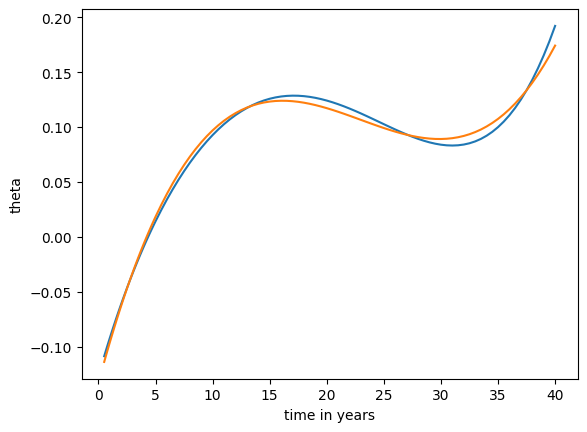

In [3]:
a = 0.1
sigma = 0.1

F = -spl.derivative()(x)
theta = -spl.derivative(n=2)(x) + a * F + sigma**2/a * (1-np.exp(-2 * a * x))

theta_spl = interpolate.UnivariateSpline(x, theta)
plt.plot(x,theta)
plt.plot(x,theta_spl(x))
plt.xlabel("time in years")
plt.ylabel("theta")

final_thetas = theta_spl(range(1,int(x[-1] + 1)))
print(len(final_thetas))
print( final_thetas)

               Month       CPI     Short    Medium      Long  Ultra-Long
Month       1.000000  0.916818  0.848315  0.874716  0.838154    0.834307
CPI         0.916818  1.000000  0.922776  0.934298  0.898917    0.898997
Short       0.848315  0.922776  1.000000  0.996327  0.987734    0.981469
Medium      0.874716  0.934298  0.996327  1.000000  0.991068    0.986396
Long        0.838154  0.898917  0.987734  0.991068  1.000000    0.998439
Ultra-Long  0.834307  0.898997  0.981469  0.986396  0.998439    1.000000


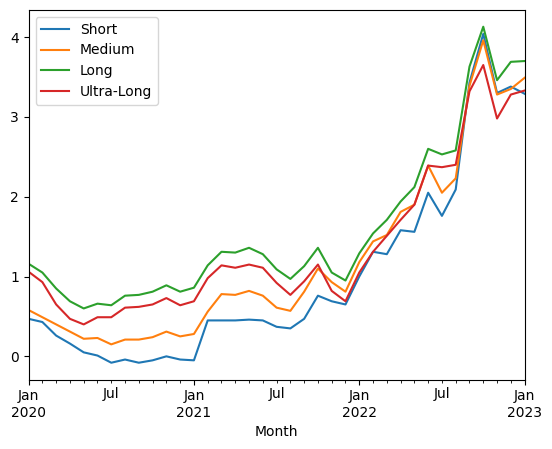

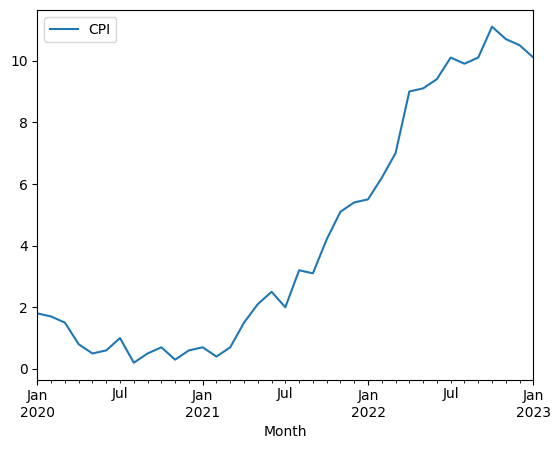

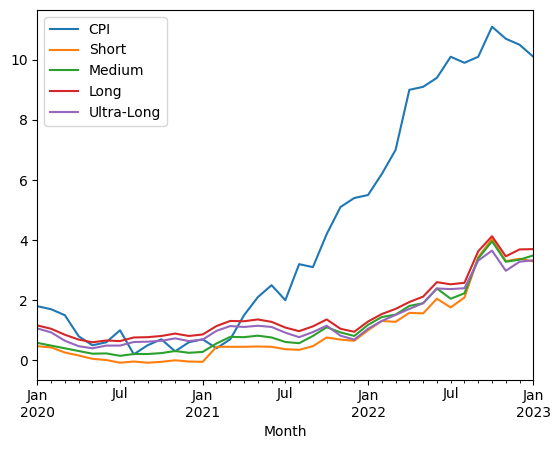

In [2]:
import pandas as pd
def strip_spaces(df):
    return df.replace(r"^ +| +$", r"", regex=True).rename(columns=lambda x: x.strip())

cpi_df = pd.read_csv('../../Data/cpi/cpi_all_1989-2022.csv')
cpi_df = strip_spaces(cpi_df)

gilt_df = pd.read_csv('../../Data/Historical_Average_Daily_Conventional_Gilt_Yields.csv')
gilt_df = strip_spaces(gilt_df)
## load both data sets and find a way to make the timesteps the same 
## then find the pmcc of them both and use that in my model
cpi_df['Month'] = pd.to_datetime(cpi_df['Month'], format="%Y %b")

gilt_df['Month'] = pd.to_datetime(gilt_df['Month'], format="%b-%Y")
cpi_df = cpi_df[~(cpi_df['Month'] < gilt_df.iloc[0]['Month'])]
cpi_df = cpi_df[~(cpi_df['Month'] < '01/01/2020')]

gilt_df['Long'] = gilt_df['Long'].str.rstrip('%').astype('float')
gilt_df['Short'] = gilt_df['Short'].str.rstrip('%').astype('float')
gilt_df['Medium'] = gilt_df['Medium'].str.rstrip('%').astype('float')
gilt_df['Ultra-Long'] = gilt_df['Ultra-Long'].str.rstrip('%').astype('float')
gilt_df = gilt_df[~(gilt_df['Month'] < '01/01/2020')]

gilt_df.plot.line(x="Month")
# gilt_df.plot.line("Month","Short")
# gilt_df.plot("Month","Medium")
# gilt_df.plot("Month","Ultra-Long")
cpi_df.plot("Month","CPI")
df = pd.merge(cpi_df, gilt_df, how="outer", on="Month")
df.plot.line(x="Month")
print(df.corr(method="pearson"))

P-value:  0.03240206989863052
-3127.5385501182063
-3123.681914693356
-3116.6996657788814
-3106.4324012067545
-3094.887132700006
-3084.130393504578
-3072.496202719934
-3070.64271651106
-3060.3185115590704
-3050.232026671259
-3038.4414745603244
-3027.9583114932025
-3056.5996104233454
-3045.8648659005394
                            AutoReg Model Results                             
Dep. Variable:                    CPI   No. Observations:                  359
Model:                     AutoReg(1)   Log Likelihood                1566.769
Method:               Conditional MLE   S.D. of innovations              0.003
Date:                Wed, 17 May 2023   AIC                          -3127.539
Time:                        11:12:02   BIC                          -3115.897
Sample:                             1   HQIC                         -3122.909
                                  359                                         
                 coef    std err          z      P>|z|      [0.02

/home/sophie/miniconda3/envs/projectpython/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


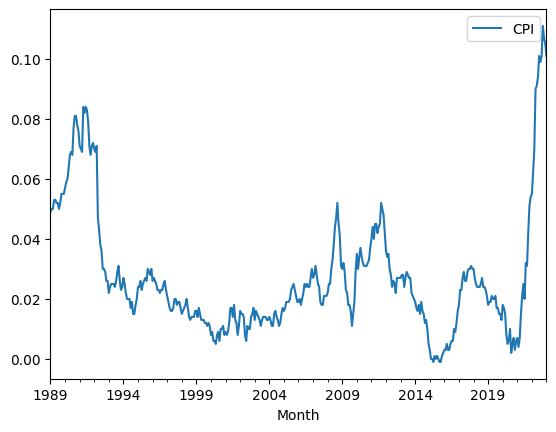

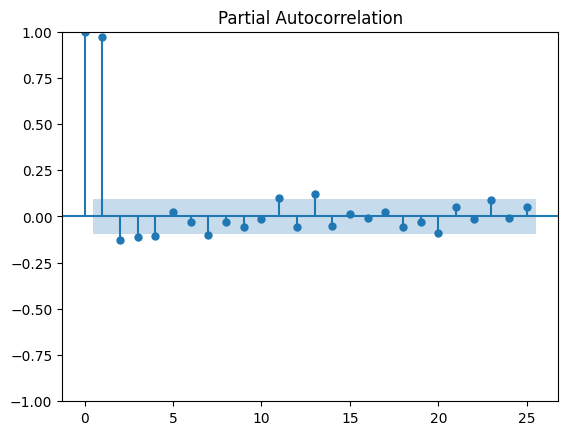

In [34]:
cpi_df = pd.read_csv('../../Data/cpi/cpi_all_1989-2022.csv')
cpi_df = strip_spaces(cpi_df)

cpi_df['Month'] = pd.to_datetime(cpi_df['Month'], format="%Y %b")
cpi_df['CPI'] = cpi_df['CPI'] * 0.01
cpi_df.plot("Month","CPI")
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
df_stationarityTest = adfuller(cpi_df['CPI'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(cpi_df['CPI'], lags=25)
plt.plot()
#
# Create training and test data
#
train_data = cpi_df['CPI'][:len(df)-50] 
test_data = cpi_df['CPI'][len(df)-50:] 
#
# Instantiate and fit the AR model with training data
#
smallestAIC = 3000000
bestModel = AutoReg(train_data, lags=1).fit()
for i in range(1,15):
    ar_model = AutoReg(train_data, lags=i).fit()
    print(ar_model.aic)
    if ar_model.aic < smallestAIC:
        smallestAIC = ar_model.aic
        bestModel = ar_model 
    
#
# Print Summary
#
print(bestModel.summary(0.05))

const     0.000383
CPI.L1    0.982335
dtype: float64


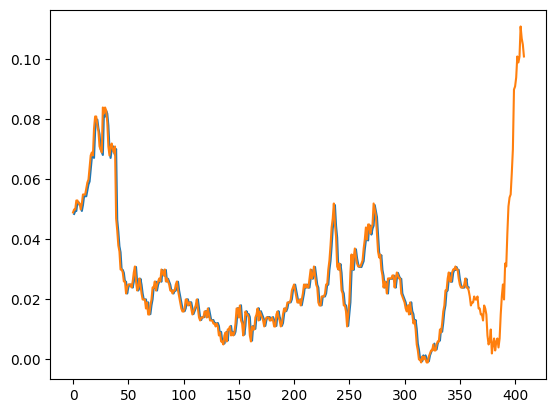

In [33]:
print(bestModel.params)
plt.plot(bestModel.fittedvalues)
plt.plot(cpi_df["CPI"])

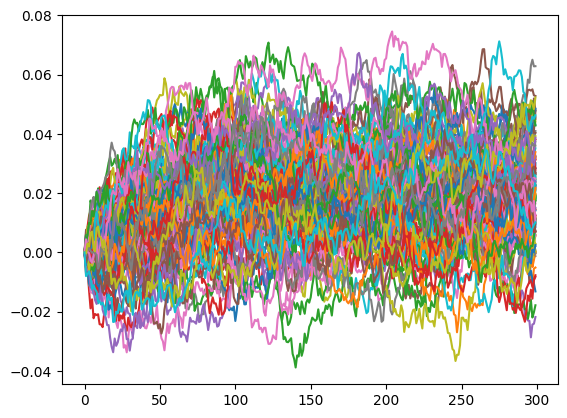

In [44]:
init = 0.02
series_len = 300
sample_series = np.zeros(series_len)
for j in range(100):
    for i in range(series_len - 1):
        sample_series[i+1] = bestModel.params[0] + sample_series[i] * bestModel.params[1] + np.random.normal(0,(0.003))
    plt.plot(sample_series)

P-value:  0.4078714157450344
                            AutoReg Model Results                             
Dep. Variable:                   Long   No. Observations:                  298
Model:                     AutoReg(1)   Log Likelihood                 113.205
Method:               Conditional MLE   S.D. of innovations              0.165
Date:                Tue, 25 Apr 2023   AIC                           -220.410
Time:                        17:06:03   BIC                           -209.328
Sample:                             1   HQIC                          -215.973
                                  298                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0383      0.027      1.416      0.157      -0.015       0.091
Long.L1        0.9869      0.007    134.546      0.000       0.973       1.001
                       

/home/sophie/miniconda3/envs/projectpython/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


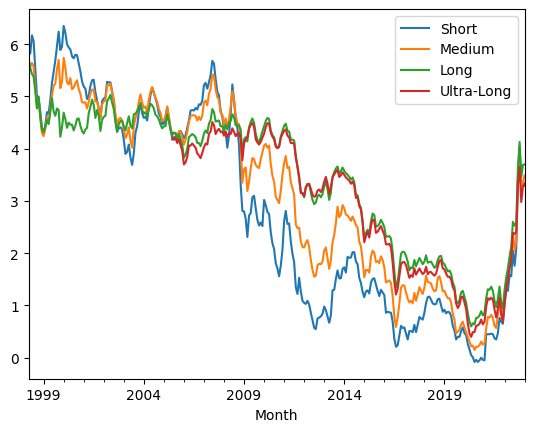

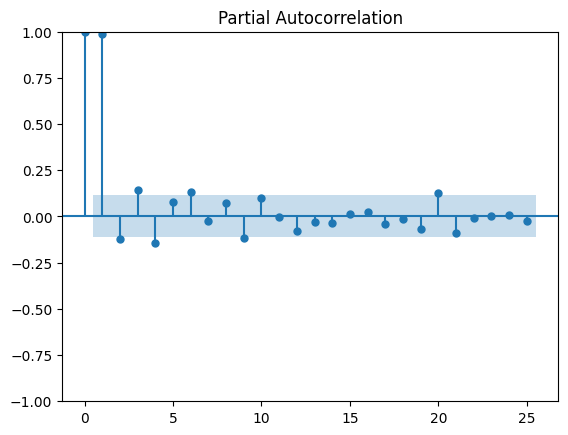

In [25]:
gilt_df = pd.read_csv('../../Data/Historical_Average_Daily_Conventional_Gilt_Yields.csv')
gilt_df = strip_spaces(gilt_df)

gilt_df['Month'] = pd.to_datetime(gilt_df['Month'], format="%b-%Y")
gilt_df['Long'] = gilt_df['Long'].str.rstrip('%').astype('float')
gilt_df['Short'] = gilt_df['Short'].str.rstrip('%').astype('float')
gilt_df['Medium'] = gilt_df['Medium'].str.rstrip('%').astype('float')
gilt_df['Ultra-Long'] = gilt_df['Ultra-Long'].str.rstrip('%').astype('float')

gilt_df.plot.line(x="Month")
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
df_stationarityTest = adfuller(gilt_df['Long'], autolag='AIC')
print("P-value: ", df_stationarityTest[1])
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(gilt_df['Long'], lags=25)

#
# Create training and test data
#
train_data = gilt_df['Long'][:len(df)-100]
test_data = gilt_df['Long'][len(df)-100:]
#
# Instantiate and fit the AR model with training data
#
ar_model = AutoReg(train_data, lags=1).fit()
#
# Print Summary
#
print(ar_model.summary(0.05))

In [9]:
def price_bond(coupon_rate, face_val, current_rate, N):
    price = 0
    for i in range(1,N):
        price += (coupon_rate * face_val) / (1 + current_rate)**(i)
    price += ((coupon_rate + 1) * face_val) / (1 + current_rate)**(N)
    return price
print(price_bond(0.05, 100, 0.04, 10))

108.110895779355
